# Calculating Grades – DSC 80, Winter 2024

In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import glob
import matplotlib.pyplot as plt
import yaml
from yaml import load
from os import path
plt.style.use('ggplot')

DataFrame downloaded by going to your respective courses assignments page on gradescope and clicking "Download Grades > Download CSV".

In [2]:
#Import data from yaml file
stream = open("../configs.yaml", 'r')
dictionary = yaml.safe_load(stream)

In [3]:
# Data Loading Fields
GRADES_FILENAME = dictionary['data_path']['grades_filename']
# ROSTER_FILENAME = 'sheets/dsc10-sp23-roster-final.csv'
# ATTENDANCE_PATH = 'sheets/discussions'

# Lab Fields
NUM_LABS = dictionary['labs']['num_labs']
MAX_LABS = dictionary['labs']['max_labs']

# Project Fields
NUM_PROJECTS = dictionary['projects']['num_projects']
MAX_PROJECTS = dictionary['projects']['max_projects']

NUM_PROJECT_CHECKPOINTS = dictionary['projects']['num_checkpoints']
MAX_PROJECT_CHECKPOINTS = dictionary['projects']['max_checkpoints']


# Midterm fields
YES_MIDTERM = dictionary['exams']['midterm']['enabled']
MIDTERM_VERSIONS = dictionary['exams']['midterm']['versions']
MIDTERM_BONUS = dictionary['exams']['midterm']['bonus']

# Final Fields
YES_FINAL = dictionary['exams']['final']['enabled']
FINAL_VERSIONS = dictionary['exams']['final']['versions']


# Discussion Fields
NUM_DI = dictionary['discussions']['num_dis']
MAX_DI = dictionary['discussions']['max_dis']

# Number of dropped assignments per category (set to 0 for no drops)
# For example, if NUM_DROPS = 2, then 2 Labs and 2 Homeworks will be dropped
# Note: Set this to 0 until the end of the quarter
NUM_DROPS = dictionary['drop_policy']['num_drops']

OVERALL_EC = dictionary['extra_credit']['overall']

In [4]:
df = pd.read_csv(GRADES_FILENAME)

# Create name column if not already present
if 'Name' not in df.columns:
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    df = df.drop(['First Name', 'Last Name'], axis=1)

#roster = pd.read_csv(ROSTER_FILENAME)

#df = df.merge(roster[['Last Name', 'First Name', 'Student ID', 'Grade Option', 'SectionId']], left_on='SID', right_on='Student ID').drop(columns=['Student ID']).set_index('SID')

# exceptions_path = path.join('sheets', EXCEPTIONS_FILENAME)
# exceptions = pd.read_csv(EXCEPTIONS_FILENAME, skip_blank_lines=True) # Drops the empty rows if there are any

# # ai = pd.read_csv('sheets/List of Involved Students - Pursuing.csv')

roster = pd.read_csv('../data/egrade-roster.tsv', sep='\t')
df = df.merge(roster, left_on='SID', right_on='Student ID').set_index('SID')
df.head()

,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Discussion 1 Reflection,Discussion 1 Reflection - Max Points,Discussion 1 Reflection - Submission Time,Discussion 1 Reflection - Lateness (H:M:S),...,Final Exam - Version B - Lateness (H:M:S),Total Lateness (H:M:S),Last Name,First Name,Student ID,Pronoun,SectionId,Final_Assigned_Egrade,Grade Option,Concurrent Flag
SID,,,,,,,,,,,,,,,,,,,,,
A16681759,Aakash Davasam,adavasam@ucsd.edu,105.0,123.0,2024-01-17 16:46:26 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,00:00:00,1069:16:40,Davasam,Aakash,A16681759,NaN,319286,NaN,P,N
A17451764,Aile Banuelos,aibanuelos@ucsd.edu,92.0,123.0,2024-01-17 16:57:25 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,00:00:00,1072:04:37,Banuelos,Aile,A17451764,NaN,319286,NaN,L,N
A18158053,Ailinna Zhang,aiz007@ucsd.edu,112.0,123.0,2024-01-13 10:41:27 -0800,00:00:00,0.0,0.0,2024-01-11 10:06:08 -0800,00:00:00,...,00:00:00,942:12:16,Zhang,Ailinna,A18158053,NaN,319286,NaN,L,N
A17332208,Akshay Medidi,amedidi@ucsd.edu,116.0,123.0,2024-01-17 06:16:01 -0800,00:00:00,0.0,0.0,2024-01-11 11:41:32 -0800,00:00:00,...,00:00:00,993:39:20,Medidi,Akshay,A17332208,NaN,319286,NaN,L,N
A16683762,Aleck Wu,a5wu@ucsd.edu,121.0,123.0,2024-01-16 20:12:02 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,00:00:00,1000:26:54,Wu,Aleck,A16683762,NaN,319286,NaN,L,N


In [5]:
df.shape

(135, 151)

In [6]:
# exceptions.head()

## Slip Days

This is the "priority order" for slip days. We use students' slip days on the assignments worth the most, but within a category we assign them sequentially.

In [7]:
assignment_order = []

# if YES_FINAL:
#     assignment_order += ['Final Project']
# if YES_MIDTERM:
#     assignment_order += ['Midterm Project']
assignment_order = assignment_order + [f'Project {i+1}' for i in range(0, NUM_PROJECTS)]
assignment_order = assignment_order + [f'Lab {i+1}' for i in range(0, NUM_LABS)]
assignment_order = assignment_order + [f'Project {i+1} (Checkpoint)' for i in range(0, NUM_PROJECT_CHECKPOINTS)]
assignment_order

['Project 1',
 'Project 2',
 'Project 3',
 'Project 4',
 'Lab 1',
 'Lab 2',
 'Lab 3',
 'Lab 4',
 'Lab 5',
 'Lab 6',
 'Lab 7',
 'Lab 8',
 'Lab 9',
 'Project 1 (Checkpoint)',
 'Project 2 (Checkpoint)',
 'Project 3 (Checkpoint)',
 'Project 4 (Checkpoint)']

Formula:

$$\text{slip days} = \text{late days} - \text{extension days}$$

## COLLAPSE PROJECT 3 & 5

In [8]:
def collapse_project(proj_num, df):
    df = df.copy()
    # get the project data sets
    proj_data = df.loc[:, df.columns.str.contains(f"Project {proj_num}")]

    proj_x_cols = proj_data.columns
    pids = df.index

    datasets = set(proj_x_cols[proj_x_cols.str.contains('Notebook')].str.extract(r'\(([a-zA-z\s]+)\)')[0])

    # combine the three into one dataframe
    cleaned_data = []
    for dataset in datasets:
        data = proj_data.loc[:, proj_x_cols.str.contains(dataset)]
        data.columns = [f'Project {proj_num}', f'Project {proj_num} - Max Points', 
                        f'Project {proj_num} - Submission Time', f'Project {proj_num} - Lateness (H:M:S)']
        # this gets rid of the rows where the student didn't submit for that dataset
        no_na = data.dropna(axis=0)

        # remove people who submitted to the wrong dataset (score is 0)
        no_na = no_na[no_na[f'Project {proj_num}'] > 0]

        cleaned_data.append(no_na)

    # concatonates all of the dataframes
    collapsed_df = pd.concat(cleaned_data, axis=0)

    try:
        df = df.drop(columns =[f'Project {proj_num} - Lateness (H:M:S)'])
    except:
        pass

    

    # merges with the original dataframe
    merged_df = pd.merge(df, collapsed_df, how='left', left_index=True, right_index=True)

    print(merged_df.columns)

    # fill any lateness that is empty
    merged_df[f'Project {proj_num} - Lateness (H:M:S)'] = merged_df[f'Project {proj_num} - Lateness (H:M:S)'].fillna('00:00:00')

    return merged_df

In [9]:
df = collapse_project(4, df)
# df = collapse_project(5, df)

Index(['Name', 'Email', 'Lab 1', 'Lab 1 - Max Points',
       'Lab 1 - Submission Time', 'Lab 1 - Lateness (H:M:S)',
       'Discussion 1 Reflection', 'Discussion 1 Reflection - Max Points',
       'Discussion 1 Reflection - Submission Time',
       'Discussion 1 Reflection - Lateness (H:M:S)',
       ...
       'Student ID', 'Pronoun', 'SectionId', 'Final_Assigned_Egrade',
       'Grade Option', 'Concurrent Flag', 'Project 4',
       'Project 4 - Max Points', 'Project 4 - Submission Time',
       'Project 4 - Lateness (H:M:S)'],
      dtype='object', length=155)


## ADD PROJECT 3 & 5 CHECKPOINT

In [10]:
# df['Project 3 (Checkpoint)'] = 1
# df['Project 3 (Checkpoint) - Max Points'] = 1
# df['Project 3 (Checkpoint) - Lateness (H:M:S)'] = '00:00:00'
# df['Project 5 (Checkpoint)'] = 1
# df['Project 5 (Checkpoint) - Max Points'] = 1
# df['Project 5 (Checkpoint) - Lateness (H:M:S)'] = '00:00:00'

In [11]:
GRACE_PERIOD = 3 / 60 # Grace period of 3 minutes.

def string_to_days(time_str):
    '''Converts an element in the Lateness column, formatted as H:M:S, to days. Factors in GRACE_PERIOD.'''
    h, m, s = time_str.split(':')
    
    # Floors at 0
    hours = max(int(h) + int(m) / 60 + int(s) / (60 * 60) - GRACE_PERIOD, 0)
    
    return int(np.ceil(hours / 24))

For each student, compute the number of slip days they used per assignment.

In [12]:
for assignment in assignment_order:
    df[f'{assignment} Slip Days'] = df[f'{assignment} - Lateness (H:M:S)'].apply(string_to_days)

In [13]:
# df['Project 5 Slip Days']#.loc['A16481071']

Then, look in the exceptions sheet. For each student there, replace their number of slip days with what the sheet says.

In [14]:
# for idx, row in exceptions.iterrows():
#     pid = row['PID']
    
#     if pid in df.index.values:
#         name = df.loc[pid, 'Name']
#         assignment = row['Assignment']
#         new_slip_days = row['Slip Days']

#         print(f"{name} had {df.loc[pid, assignment + ' Slip Days']} slip days on {assignment} but now has {new_slip_days}.")

#         df.loc[pid, assignment + ' Slip Days'] = new_slip_days
#     else:
#         print(pid, 'no longer in class')

In [15]:
# if exceptions.loc[(exceptions['PID'] == 'A16660228') & (exceptions['Assignment'] == 'Lab 3'), :].shape[0] > 0:
#     print(True)

In [16]:
# exceptions

### Giving Back Slip Days

If a student used slip days on their lowest homework or lab, they need to get those slip days back. We identify such cases below in the `to_adjust` dictionary and saved them to `sheets/adjustments.json`, which we now load as `adjustments`.

In [17]:
# def zero_out(pid, assignment):
#     df.loc[pid, assignment] = 0.0
#     df.loc[pid, assignment + ' Slip Days'] = 0
#     print(f"Removed {pid}'s submission of {assignment}")

In [18]:
# adj_path = 'sheets/adjustments.json'
# if os.path.exists(adj_path):
#     with open(adj_path, 'r') as f:
#         adjustments = json.load(f)
        
#     for pid in adjustments:
#         for assignment in adjustments[pid]:
#             zero_out(pid, assignment)
            
# else:
#     print('sheets/adjustments.json not found.')

### Calculating category totals with drops

In [19]:
# Helper functions/variables for all assignment types
def get_proportion_assignment(r, assignment_name):
    num = r[assignment_name]
    den = r[assignment_name + ' - Max Points']
    
    return num / den

## LABS

Calculate the proportion per lab

In [20]:
for i in range(1, NUM_LABS + 1):
    assignment_name = f'Lab {i}'
    df[assignment_name + ' Raw'] = df.apply(get_proportion_assignment, axis=1, assignment_name=assignment_name)

If you want to release other lab grades zeroed out, run the cell below

In [21]:
# # zeroing out the labs that haven't been released or graded yet
# for i in range(NUM_LABS+1, MAX_LABS+1):
#     assignment_name = f'Lab {i}'
#     df[assignment_name] = 0
#     df[assignment_name + ' - Max Points'] = 0
#     df[assignment_name + ' Raw'] = 0
#     df[assignment_name + ' Slip Days'] = 0 # need to output the number of slip days per assignment

## Projects

Here we calculate the proportions per Projects

In [22]:
for i in range(1, NUM_PROJECTS+1):
    assignment_name = f'Project {i}'
    df[assignment_name + ' Raw'] = df.apply(get_proportion_assignment, axis=1, assignment_name=assignment_name)

In [23]:
# zeroing out the projects that haven't been released or graded yet
for i in range(NUM_PROJECTS+1, MAX_PROJECTS+1):
    # if i == 4:
    #     i = "4A"
    # elif i == 5:
    #     i = "4B"
    assignment_name = f'Project {i}'
    df[assignment_name] = 0
    df[assignment_name + ' - Max Points'] = 0
    df[assignment_name + ' Raw'] = 0
    df[assignment_name + ' Slip Days'] = 0 # need to output the number of slip days per assignment

In [24]:
def calculate_project_total(r):
    project_scores = r[[f'Project {i} Raw' for i in range(1, MAX_PROJECTS+1)] + ['Project 4 Raw']].fillna(0)
    project_scores = np.sort(project_scores)
    return project_scores.mean()

In [25]:
df.loc['A16681759', ['Project 1 Raw', 'Project 2 Raw', 'Project 3 Raw', 'Project 4 Raw']]

Project 1 Raw    0.893443
Project 2 Raw    0.970874
Project 3 Raw        0.91
Project 4 Raw       0.975
Name: A16681759, dtype: object

In [26]:
df['Project Total'] = df.apply(calculate_project_total, axis=1)

In [27]:
df['Project Total'].describe()

count    135.000000
mean       0.877365
std        0.139832
min        0.000000
25%        0.860075
50%        0.906458
75%        0.943043
max        0.996117
Name: Project Total, dtype: float64

In [28]:
# df['Project Total'].head(50)

## Project Checkpoints

We assume that if a project is being calculated for we have a checkpoint to calculate

In [29]:
for i in range(1, NUM_PROJECT_CHECKPOINTS+1):
    assignment_name = f'Project {i} (Checkpoint)'
    df[assignment_name + ' Raw'] = df.apply(get_proportion_assignment, axis=1, assignment_name=assignment_name)

In [30]:
# zeroing out the project Checkpoints that haven't been released or graded yet
for i in range(NUM_PROJECT_CHECKPOINTS+1, MAX_PROJECT_CHECKPOINTS+1):
    # if i == 4:
    #     i = "4A"
    # elif i == 5:
    #     i = "4B"
    assignment_name = f'Project {i}'
    df[assignment_name] = 0
    df[assignment_name + ' - Max Points'] = 0
    df[assignment_name + ' Raw'] = 0
    df[assignment_name + ' Slip Days'] = 0 # need to output the number of slip days per assignment
    assignment_name = f'Project {i} (Checkpoint)'
    df[assignment_name] = 0
    df[assignment_name + ' - Max Points'] = 0
    df[assignment_name + ' Raw'] = 0
    df[assignment_name + ' Slip Days'] = 0 # need to output the number of slip days per assignment

In [31]:
def calculate_project_checkpoint_total(r):

    # project_scores = r[[f'Project {i} (Checkpoint) Raw' if i <= 3 else 'Project 4A (Checkpoint) Raw' if i == 4 else 'Project 4B (Checkpoint) Raw' for i in range(1, MAX_PROJECT_CHECKPOINTS+1)]].fillna(0)
    
    project_scores = r[[f'Project {i} (Checkpoint) Raw' for i in range(1, MAX_PROJECT_CHECKPOINTS+1)] + ['Project 4 (Checkpoint) Raw']].fillna(0)
    return project_scores.mean()

In [32]:
df['Project Checkpoint Total'] = df.apply(calculate_project_checkpoint_total, axis=1)

In [33]:
df['Project Checkpoint Total'].describe()

count    135.000000
mean       0.959741
std        0.166046
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Project Checkpoint Total, dtype: float64

In [34]:
df.loc['A17417301']#[[f'Project {i} (Checkpoint) Raw' for i in range(1, MAX_PROJECT_CHECKPOINTS+1)]]

Name                                   Hana Tjendrawasi
Email                             htjendrawasi@ucsd.edu
Lab 1                                              83.0
Lab 1 - Max Points                                123.0
Lab 1 - Submission Time       2024-01-17 11:48:42 -0800
                                        ...            
Project 1 (Checkpoint) Raw                          1.0
Project 2 (Checkpoint) Raw                          1.0
Project 3 (Checkpoint) Raw                          1.0
Project 4 (Checkpoint) Raw                          0.1
Project Checkpoint Total                           0.64
Name: A17417301, Length: 191, dtype: object

### Apply extension and days

Applies the appropriate slip days (accounting for extensions) to assignments

In [35]:
def lowest_lab_name(row):
    lab_rows = row[row.index.isin([f'Lab {i+1} Raw' for i in range(0, NUM_LABS)])]
    lowest_lab_index = lab_rows.astype(float).argmin()
    lowest_lab_name = lab_rows.index[lowest_lab_index].strip(' Raw')
    
    return lowest_lab_name

In [36]:
def process_slip_days_for_row(r):
    slip_days = 0
    accepted_late_assignments = []
    not_accepted_late_assignments = []

    lowest_lab = lowest_lab_name(r)

    pid = r.name

    # iterate through assigments in priority order
    for assignment in assignment_order:
        # skip lowest lab
        if assignment == lowest_lab:
            df.loc[pid, f'{assignment} Slip Days'] = 0
            continue
        
        # don't use slip days on lab if it's over 1 day or if 
        # if exceptions.loc[(exceptions['PID'] == pid) & (exceptions['Assignment'] == assignment), :].shape[0] > 0:
        #     continue

        # check how many slip days were used on the current assignment
        assignment_slip_days = r.loc[f'{assignment} Slip Days']
        
        # slip days were used
        if assignment_slip_days > 0:
            # if there aren't enough slip days available
            # add to the not accepted list
            if slip_days + assignment_slip_days <= 7:
                # add the slip days used to total amount used
                slip_days += assignment_slip_days
                accepted_late_assignments.append(assignment)
            else:
                not_accepted_late_assignments.append(assignment)
    return slip_days, accepted_late_assignments,  not_accepted_late_assignments

def show_slip_days(pid):
    return df.loc[pid, df.columns[df.columns.str.contains('Slip Days')]].iloc[0]

### Calculate Slip Days and add to DataFrame

In [37]:
df =  df#.iloc[:-4]
df

,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Discussion 1 Reflection,Discussion 1 Reflection - Max Points,Discussion 1 Reflection - Submission Time,Discussion 1 Reflection - Lateness (H:M:S),...,Project 1 Raw,Project 2 Raw,Project 3 Raw,Project 4 Raw,Project Total,Project 1 (Checkpoint) Raw,Project 2 (Checkpoint) Raw,Project 3 (Checkpoint) Raw,Project 4 (Checkpoint) Raw,Project Checkpoint Total
SID,,,,,,,,,,,,,,,,,,,,,
A16681759,Aakash Davasam,adavasam@ucsd.edu,105.0,123.0,2024-01-17 16:46:26 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,0.893443,0.970874,0.91,0.9750,0.944863,1.000000,NaN,1.0,1.0,0.800000
A17451764,Aile Banuelos,aibanuelos@ucsd.edu,92.0,123.0,2024-01-17 16:57:25 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,0.622951,0.786408,0.68,0.7125,0.702872,0.846154,1.0,1.0,1.0,0.969231
A18158053,Ailinna Zhang,aiz007@ucsd.edu,112.0,123.0,2024-01-13 10:41:27 -0800,00:00:00,0.0,0.0,2024-01-11 10:06:08 -0800,00:00:00,...,0.893443,1.000000,0.90,0.9700,0.946689,1.000000,1.0,1.0,1.0,1.000000
A17332208,Akshay Medidi,amedidi@ucsd.edu,116.0,123.0,2024-01-17 06:16:01 -0800,00:00:00,0.0,0.0,2024-01-11 11:41:32 -0800,00:00:00,...,0.795082,0.699029,0.85,0.9000,0.828822,1.000000,1.0,1.0,1.0,1.000000
A16683762,Aleck Wu,a5wu@ucsd.edu,121.0,123.0,2024-01-16 20:12:02 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,0.877049,0.825243,0.83,1.0000,0.906458,1.000000,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A16414249,Zening Wang,zew003@ucsd.edu,96.0,123.0,2024-01-17 22:47:09 -0800,00:00:09,NaN,0.0,NaN,00:00:00,...,0.811475,0.912621,0.72,0.9900,0.884819,1.000000,1.0,1.0,1.0,1.000000
A17462025,Zhenghao Gong,z3gong@ucsd.edu,107.0,123.0,2024-01-15 08:38:00 -0800,00:00:00,0.0,0.0,2024-01-10 21:31:42 -0800,00:00:00,...,0.975410,0.902913,0.91,0.9850,0.951664,1.000000,1.0,1.0,1.0,1.000000
A16227798,Zhihan Li,zhl023@ucsd.edu,116.0,123.0,2024-01-17 01:28:26 -0800,00:00:00,NaN,0.0,NaN,00:00:00,...,0.926230,1.000000,0.93,0.8575,0.914246,1.000000,1.0,1.0,1.0,1.000000


In [38]:
applied = df.apply(process_slip_days_for_row, axis=1)
df['Used Slip Days'] = applied.str[0]
df['Slip Days Remaining'] = 7 - df['Used Slip Days']
df['Accepted Late Assignments'] = applied.str[1]
df['Late Assignments Past 7 Slip Days'] = applied.str[2]

<AxesSubplot:>

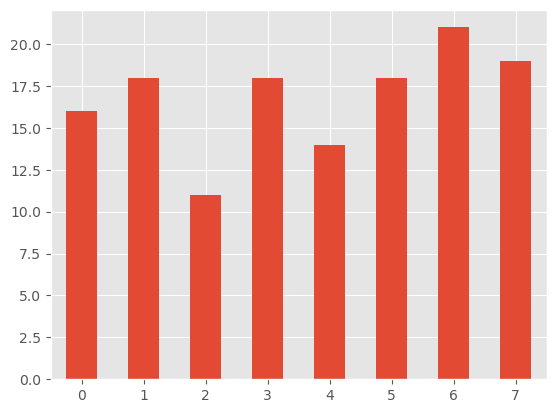

In [39]:
df['Used Slip Days'].value_counts().sort_index().plot.bar(rot=0)

Now, we zero out the assignments that are "past slip days". There should only be a few students who this applies to.

In [40]:
past_six = df.loc[df['Late Assignments Past 7 Slip Days'].str.len() > 0, ['Name', 'Accepted Late Assignments', 'Late Assignments Past 7 Slip Days']]
past_six

,Name,Accepted Late Assignments,Late Assignments Past 7 Slip Days
SID,,,
A16821776,Arnav Saxena,"[Project 1, Project 2, Project 3, Lab 4, Proje...",[Project 4 (Checkpoint)]
A16979798,Kailey Wen,"[Project 1, Project 2, Project 3, Lab 3, Lab 6...",[Project 3 (Checkpoint)]
A17638982,Yujin Lee,"[Project 1, Project 2, Project 3]","[Lab 2, Lab 4]"


In [41]:
for r in past_six.iterrows():
    pid = r[0]
    if r[1]['Name'] == 'Eric Pham':
        print(pid)
    late_assignments = r[1]['Late Assignments Past 7 Slip Days']
    for assignment in late_assignments:
        df.loc[pid, assignment + ' Raw'] = 0.0

In [42]:
# df.loc['A16834749', 'Project 4 (Checkpoint) Raw']

In [43]:
df['Project Checkpoint Total'] = df.apply(calculate_project_checkpoint_total, axis=1)
df['Project Total'] = df.apply(calculate_project_total, axis=1)

In [44]:
def calculate_lab_total(r):
    lab_scores = r[[f'Lab {i} Raw' for i in range(1, MAX_LABS+1)]].fillna(0)
    lab_scores = np.sort(lab_scores)
    return lab_scores[NUM_DROPS:].mean()

In [45]:
# # zeroing out the labs that haven't been released or graded yet
for i in range(NUM_LABS+1, MAX_LABS+1):
    assignment_name = f'Lab {i}'
    df[assignment_name] = 0
    df[assignment_name + ' - Max Points'] = 0
    df[assignment_name + ' Raw'] = 0

In [46]:
df['Lab Total'] = df.apply(calculate_lab_total, axis=1)

In [47]:
# Find the dropped labs
def find_dropped_labs(r):
    lab_scores = r[[f'Lab {i} Raw' for i in range(1, NUM_LABS+1)]].fillna(0)
    dropped_labs = np.argsort(np.array(lab_scores))[:NUM_DROPS]
    dropped_labs = np.sort(dropped_labs) + 1
    dropped_labs = [f'Lab {l}' for l in dropped_labs]
    return ', '.join(dropped_labs)

In [48]:
df['Dropped Labs'] = df.apply(find_dropped_labs, axis=1)

In [49]:
df['Dropped Labs'] # Could be empty if no drops were made

SID
A16681759    Lab 2
A17451764    Lab 1
A18158053    Lab 9
A17332208    Lab 2
A16683762    Lab 6
             ...  
A16414249    Lab 3
A17462025    Lab 1
A16227798    Lab 9
A16420131    Lab 1
A17427885    Lab 8
Name: Dropped Labs, Length: 135, dtype: object

In [50]:
df['Lab Total'].describe()

count    135.000000
mean       0.920831
std        0.149046
min        0.000000
25%        0.921404
50%        0.956786
75%        0.976879
max        1.006859
Name: Lab Total, dtype: float64

In [51]:
def lowest_lab_name(row):
    lab_rows = row[row.index.isin([f'Lab {i+1} Raw' for i in range(0, NUM_LABS)])]
    lowest_lab_index = lab_rows.astype(float).argmin()
    lowest_lab_name = lab_rows.index[lowest_lab_index].strip(' Raw')
    
    return lowest_lab_name

### Giving Back Slip Days

Some students ran out of slip days but used slip days on their lowest lab/homework, which was dropped. In such cases, we will "delete" their submissions for the dropped assignments by setting their score and submission time to 0. This way, the same assignment is dropped but they don't waste their slip days on it.

The issue is we need to run the above code in order to know what is dropped, but then we need to go and adjust the above code to make it all right. Workflow:
- Run the code below once to figure out what to adjust and save it to `sheets/adjustments.json`.
- Above, if `adjustments.json` exists, it will read what's there and 0 out the submissions for these students.
- Then, the second time the code below is run, `to_adjust` should be empty, since this will already have been handled.

In [52]:
# to_adjust = {}
# def used_slip_days_on_lowest(r):
#     hw = r['Dropped Homeworks']
#     lab = r['Dropped Labs']
    
#     hw_slip_days = r[f'{hw} Slip Days']
#     lab_slip_days = r[f'{lab} Slip Days']
    
#     to_adjust[r.name] = []
       
#     if hw_slip_days > 0:
#         to_adjust[r.name].append(hw)

#     if lab_slip_days > 0:
#         to_adjust[r.name].append(lab)
        
#     if len(to_adjust[r.name]) == 0:
#         to_adjust.pop(r.name)
        
# df.apply(used_slip_days_on_lowest, axis=1);

# # # Should be empty if the adjustments are taken care of
# # if len(to_adjust) > 0:
# #     with open('sheets/adjustments.json', 'w') as f:
# #         json.dump(to_adjust, f)
# # else:
# #     print('adjustments made')

## PROJECTS AND EXAMS

Combine Midterm Exam columns if they are in different sections

MIDTERM EXAM

In [53]:
# df['Midterm Exam'] = df['Midterm Exam'].fillna(0)
# df['Midterm Exam Raw'] = df['Midterm Exam'] / df['Midterm Exam - Max Points']


if YES_MIDTERM:
    midterm_total = np.zeros(df.shape[0])
    for version in MIDTERM_VERSIONS:
        midterm_total += df[f'Midterm Exam - Version {version}'].fillna(0)
    df[f'Midterm Exam'] = midterm_total #+ dictionary['exams']['midterm']['bonus']
    df[f'Midterm Exam - Max Points'] = df[f'Midterm Exam - Version A - Max Points']
    df[f'Midterm Exam Raw Pre-EC'] = midterm_total/df[f'Midterm Exam - Version A - Max Points']
    
#     df['Midterm Exam Total'] = df['Midterm Exam Raw']
    df['Midterm Mean'] = df['Midterm Exam Raw Pre-EC'].dropna().mean()
    df['Midterm std'] = df['Midterm Exam Raw Pre-EC'].dropna().std(ddof=0)
    for version in MIDTERM_VERSIONS:
        df.drop(f'Midterm Exam - Version {version}', axis=1, inplace=True)
        df.drop(f'Midterm Exam - Version {version} - Max Points', axis=1, inplace=True)
        df.drop(f'Midterm Exam - Version {version} - Lateness (H:M:S)', axis=1, inplace=True)
        df.drop(f'Midterm Exam - Version {version} - Submission Time', axis=1, inplace=True)

In [54]:
def find_old_stats():
    new_df = pd.DataFrame()
    final_total = np.zeros(df.shape[0])
    redemption_total = np.zeros(df.shape[0])
    for version in FINAL_VERSIONS:
        cur_version_final = pd.read_csv(f"../data/old-set-scores/Final_Exam_-_Version_{version}_scores.csv").set_index('SID')
        redmp_questions = cur_version_final.columns[cur_version_final.columns.str.contains("(R)")]
        redmp_scores = cur_version_final[redmp_questions].sum(axis=1)
        # merge the redemp_scores with df
        new_df = new_df.assign(**{f"redepmtion_v{version}":redmp_scores}, left_index=True, right_index=True)
#         final_total += new_df[f'Final Exam - Version {version}'].fillna(0)
    return new_df

In [55]:
redem = find_old_stats()
redem['score'] = redem.iloc[:, 0] + redem.iloc[:, -1]

/var/folders/pd/w73mdrsj2836_7gp0brr2q7r0000gn/T/ipykernel_8060/3070273779.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  redmp_questions = cur_version_final.columns[cur_version_final.columns.str.contains("(R)")]


In [56]:
(redem['score'] / 46).mean()

0.6446191797718162

In [57]:
(redem['score'] / 46).std()

0.24808183675732415

In [58]:
def z_score(ser, is_redem=False):
    if not is_redem:
        return (ser - ser.dropna().mean()) / ser.dropna().std(ddof=0)
    else:
        return (ser - (redem['score'] / 46).mean()) / (redem['score'] / 46).std()

def individual_student_redemption(row):
    if row['Redemption Successful']:
        # print(df['Midterm Exam Raw'].dropna().std(ddof=0))
        # print(df['Midterm Exam Raw'].dropna().mean())
        post_redemption = row['Midterm Redemption Part z-score'] * df['Midterm Exam Raw Pre-EC'].dropna().std(ddof=0) + df['Midterm Exam Raw Pre-EC'].dropna().mean()
        return np.clip(post_redemption, 0, 1)
    else:
        return row['Midterm Exam Raw Pre-EC']

In [59]:
if YES_FINAL:
    final_total = np.zeros(df.shape[0])
    redemption_total = np.zeros(df.shape[0])
    for version in FINAL_VERSIONS:
        cur_version_final = pd.read_csv(f"../data/Final_Exam_Version_Set_Scores/Final_Exam_-_Version_{version}_scores.csv").set_index('SID')
        redmp_questions = cur_version_final.columns[cur_version_final.columns.str.contains("(R)")]
        redmp_scores = cur_version_final[redmp_questions].sum(axis=1)
        # merge the redemp_scores with df
        df = df.assign(**{f"redepmtion_v{version}":redmp_scores}, left_index=True, right_index=True)
        final_total += df[f'Final Exam - Version {version}'].fillna(0)
    df[f'Final Exam'] = final_total + dictionary['exams']['final']['bonus']
    df[f'Final Exam - Max Points'] = df[f'Final Exam - Version A - Max Points']
    df[f'Final Exam Raw'] = final_total/df[f'Final Exam - Version A - Max Points']
    df['Final Exam Total'] = df['Final Exam Raw']

    df['Redemption Score'] = df[[f"redepmtion_v{version}" for version in FINAL_VERSIONS]].sum(axis=1) / 46
    MEAN_MID_RE, STD_MID_RE = df['Redemption Score'].mean(), df['Redemption Score'].std(ddof=0)

    df['Midterm z-score'] = z_score(df['Midterm Exam Raw Pre-EC'])
    df['Midterm Redemption Part z-score'] = z_score(df['Redemption Score'], is_redem=True)
    df['Redemption Successful'] = df['Midterm Redemption Part z-score'] > df['Midterm z-score']
    df['Midterm Mean'] = df['Midterm Exam Raw Pre-EC'].dropna().mean()
    # df['Redemption Successful'].sum()
    df['Midterm Exam Raw Post-Redemption Pre-EC'] = df.apply(individual_student_redemption, axis=1)
    df['Midterm Exam Raw Post-Redemption Post-EC'] = df['Midterm Exam Raw Post-Redemption Pre-EC'] + 0.025

    for version in FINAL_VERSIONS:
        df.drop(f'Final Exam - Version {version}', axis=1, inplace=True)
        df.drop(f'Final Exam - Version {version} - Max Points', axis=1, inplace=True)
        df.drop(f'Final Exam - Version {version} - Lateness (H:M:S)', axis=1, inplace=True)
        df.drop(f'Final Exam - Version {version} - Submission Time', axis=1, inplace=True)



# redmp_questions = final_exam.columns[final_exam.columns.str.contains("(R)")]
# mid_part_score = (final_exam[redmp_questions].sum(axis=1) / 16).to_frame('Midterm Redemption Part Score')
# # MEAN_MID_RE, STD_MID_RE = mid_part_score.mean(), mid_part_score.std(ddof=0)
# df = df.merge(mid_part_score, left_index=True, right_index=True, how='left')
# df.head()

# list(df.columns)
# # MEAN_MID, STD_MID = df['Midterm Exam Raw'].mean(), df['Midterm Exam Raw'].std(ddof=0)
# df['Midterm z-score'] = z_score(df['Midterm Exam Raw'])
# df['Midterm Redemption Part z-score'] = z_score(df['Midterm Redemption Part Score'])
# df['Redemption Successful'] = df['Midterm Redemption Part z-score'] > df['Midterm z-score']
# df['Midterm Mean'] = df['Midterm Exam Raw'].dropna().mean()
# df['Midterm std'] = df['Midterm Exam Raw'].dropna().std(ddof=0)
# df['Redemption Successful'].sum()

# def individual_student_redemption(row):
#     if row['Redemption Successful']:
#         # print(df['Midterm Exam Raw'].dropna().std(ddof=0))
#         # print(df['Midterm Exam Raw'].dropna().mean())
#         post_redemption = row['Midterm Redemption Part z-score'] * df['Midterm Exam Raw'].dropna().std(ddof=0) + df['Midterm Exam Raw'].dropna().mean()
#         return np.clip(post_redemption, 0, 1)
#     else:
#         return row['Midterm Exam Raw']
# df['Midterm Final Raw'] = df.apply(individual_student_redemption, axis=1)
# df['Midterm Final Raw']

/var/folders/pd/w73mdrsj2836_7gp0brr2q7r0000gn/T/ipykernel_8060/1703019662.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  redmp_questions = cur_version_final.columns[cur_version_final.columns.str.contains("(R)")]


In [60]:
# clobber_pids = '''A16305027
# A17493614
# A17211629
# A17574318'''.split('\n')
# clobber_pids

In [61]:
# took_midterm = df[df['Midterm Exam Raw'] > 0]['Midterm Exam Raw']
# took_final = df[df['Final Exam Raw'] > 0]['Final Exam Raw']

In [62]:
# def new_midterm_score(final):
#     assert 0 <= final <= 1, 'needs to be final score as a proportion'
#     final_z = (final - took_final.mean()) / np.std(took_final, ddof=0)
#     return np.clip(took_midterm.mean() + np.std(took_midterm, ddof=0) * final_z, 0, 1)

In [63]:
# df['Midterm Clobbered'] = False

In [64]:
# for pid in clobber_pids:
#     final = df.loc[pid, 'Final Exam Raw']
#     old_midterm = df.loc[pid, 'Midterm Exam Raw']
#     new_midterm = new_midterm_score(final)
#     df.loc[pid, 'Midterm Exam Raw'] = new_midterm
#     df.loc[pid, 'Midterm Exam'] = new_midterm * 70
#     df.loc[pid, 'Midterm Clobbered'] = True
#     print(df.loc[pid, 'Name'], '\nOld:', old_midterm, 'New:', new_midterm)

In [65]:
# final_exam = pd.read_csv("sheets/Final_Exam_scores.csv")
# final_exam = final_exam.set_index('SID')
# final_exam.head()

In [66]:
# mid_part_score

In [67]:
# redmp_questions = final_exam.columns[final_exam.columns.str.contains("(R)")]
# mid_part_score = (final_exam[redmp_questions].sum(axis=1) / 16).to_frame('Midterm Redemption Part Score')
# # MEAN_MID_RE, STD_MID_RE = mid_part_score.mean(), mid_part_score.std(ddof=0)
# df = df.merge(mid_part_score, left_index=True, right_index=True, how='left')
# df.head()


In [68]:
# list(df.columns)
# # MEAN_MID, STD_MID = df['Midterm Exam Raw'].mean(), df['Midterm Exam Raw'].std(ddof=0)
# df['Midterm z-score'] = z_score(df['Midterm Exam Raw'])
# df['Midterm Redemption Part z-score'] = z_score(df['Midterm Redemption Part Score'])
# df['Redemption Successful'] = df['Midterm Redemption Part z-score'] > df['Midterm z-score']

# df['Redemption Successful'].sum()

In [69]:
# df['Midterm Redemption Part z-score']

In [70]:
# def individual_student_redemption(row):
#     if row['Redemption Successful']:
#         # print(df['Midterm Exam Raw'].dropna().std(ddof=0))
#         # print(df['Midterm Exam Raw'].dropna().mean())
#         post_redemption = row['Midterm Redemption Part z-score'] * df['Midterm Exam Raw'].dropna().std(ddof=0) + df['Midterm Exam Raw'].dropna().mean()
#         return np.clip(post_redemption, 0, 1)
#     else:
#         return row['Midterm Exam Raw']
# df['Midterm Final Raw'] = df.apply(individual_student_redemption, axis=1)
# df['Midterm Final Raw']

In [71]:
# df['Midterm Final Raw'] > df['Midterm Exam Raw']

## DISCUSSION

### Load Initial Sheets
Please place all required csvs in the sheets folder.
<br>
<br>
Make sure to change all fields below to your current required fields

Note: later on, we'll add the roster, but we don't need it for now.

**Note to Tiffany:**
- Right now, there is no logic for discussions.
- In the `sheets/` folder, add another folder called `discussions/` and add each discussion sheet separately.
- Then, in the section called "DISCUSSIONS", read from each of the files in that folder and add a column for each discussion. For each student, this should contain "1" if the student came to that discussion and "0" otherwise.
- Lastly, tally up all discussion grades as a proportion between 0 and 1 (# attended / 8).

This generates a dictionary containing all the discussion attendance.

In [72]:
di1 = pd.read_csv('../data/DSC80 Wi24 - Disc1.csv')['Email Address']
for email in di1:
    if email in df['Email'].values:
        sid = df[df['Email'] == email].index[0]
        df.loc[sid, 'Discussion 1 Reflection'] = 1
    else:
        pass

In [73]:
df['Discussion Week 1 Raw'] = (df['Discussion 1 Reflection'] == 1).astype(int)

for i in range(1, NUM_DI):
    df[f'Discussion Week {i + 1} Raw'] = (df[f'Lab {i} Reflection'] > 0).astype(int)


In [74]:
for i in range(NUM_DI + 1, MAX_DI + 1):
    col = f'Discussion Week {i}'
    df[col] = 0

In [75]:
def calculate_discussion_total(r):
    return max(0, r[r.index.str.contains('Discussion Week')].sum())

In [76]:
df['Discussion Raw'] = df.apply(calculate_discussion_total, axis=1)
df['Discussion Weeks'] = df.apply(lambda r: list((r[r.index.str.contains('Discussion Week')] > 0).astype(int)), axis=1)
df['Discussion Weeks']

SID
A16681759    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
A17451764    [1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
A18158053    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
A17332208    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
A16683762    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                          ...              
A16414249    [1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
A17462025    [0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
A16227798    [0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
A16420131    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
A17427885    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Name: Discussion Weeks, Length: 135, dtype: object

In [77]:
type(df['Discussion Weeks'].iloc[0][0])

int

In [78]:
a = "[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]"
type(eval(a))

list

In [79]:
df['Discussion Raw'].max()

10

Global extra credit

In [80]:
# df['CAPEs Extra Credit'] = 1

In [81]:
# TODO: AT THE END OF THE QUARTER, CHANGE DISCUSSION RAW's VALUE TO 2
# weights = {'Lab Total': 30,
#            'Project Total': 35,
#            'Project Checkpoint Total': 5,
#            'Midterm Final Raw': 10,
#            'Final Exam Raw': 20,
#          # TODO-
#            'Discussion Raw': 2.7,
#            'CAPEs Extra Credit': 0.5
#         }

weights = dictionary['assignment_weights']
weights

{'lab': 0.25,
 'project': 0.3,
 'project_checkpoint': 0.05,
 'midterm_exam': 0.15,
 'final_exam': 0.25,
 'discussion': 0.02}

In [82]:
weights_columns = [f'{key.title().replace("_", " ")} Total' for key in weights.keys()]
if not YES_MIDTERM:
    del weights_columns[weights_columns.index('Midterm Exam Total')]
if not YES_FINAL:
    del weights_columns[weights_columns.index('Final Exam Total')]
weights_columns

['Lab Total',
 'Project Total',
 'Project Checkpoint Total',
 'Midterm Exam Total',
 'Final Exam Total',
 'Discussion Total']

In [83]:
df["Max Possible Points"] = NUM_LABS/ MAX_LABS * weights['lab'] \
    + NUM_PROJECTS/ MAX_PROJECTS * weights['project'] + \
          NUM_PROJECT_CHECKPOINTS/ MAX_PROJECT_CHECKPOINTS * weights['project_checkpoint']
if YES_MIDTERM:
    df["Max Possible Points"] += weights['midterm_exam']
if YES_FINAL:
    df["Max Possible Points"] += weights['final_exam']
df["Max Possible Points"] *= 100
df["Max Possible Points"].max()

100.0

In [84]:
weights

{'lab': 0.25,
 'project': 0.3,
 'project_checkpoint': 0.05,
 'midterm_exam': 0.15,
 'final_exam': 0.25,
 'discussion': 0.02}

In [85]:
df['Midterm Exam Total'] = df['Midterm Exam Raw Post-Redemption Post-EC']

In [86]:
# def calculate_overall_score(df: pd.DataFrame, weights):
#     """
#     Calculates the overall score for the students, even if assignments don't exist yet.
#     """
#     # Iterate through weights and if 
#     return np.sum([weights[w] * df.loc[:, w] if w in df.columns  else [0] * df.shape[0] for w in weights], axis=0)



# def calculate_overall_score(df: pd.DataFrame, weights):
#     """
#     Calculates the overall score for the students, even if assignments don't exist yet.
#     """
#     # Iterate through weights and if 
#     score = np.sum([weights[w] * df.loc[:, f'{w.title().replace("_", " ")} Total'] if f'{w.title().replace("_", " ")} Total' in df.columns else [0] * df.shape[0] for w in weights], axis=0)
#     if YES_FINAL:
#         score -= df['Midterm Exam Total'] * weights['midterm_exam']
#     return score

def calculate_overall_score(df: pd.DataFrame, weights):
    """
    Calculates the overall score for the students, even if assignments don't exist yet.
    """
    # Initialize the accumulator
    accumulated_scores = np.zeros(df.shape[0])

    # Loop through the weights
    for w in weights:
        column_name = f'{w.title().replace("_", " ")} Total'
        print(column_name)
        if column_name in df.columns:
            # If the column exists, add the weighted score
            
            accumulated_scores += weights[w] * df[column_name]
            print(w)
        else:
            # If the column does not exist, add zeros
            accumulated_scores += np.zeros(df.shape[0])
            print("---", w)

#     # Adjust the score if YES_FINAL is True
#     if YES_FINAL:
#         accumulated_scores -= df['Midterm Exam Total'] * weights['midterm_exam']
#         accumulated_scores += df['Midterm Final Raw'] * weights['midterm_exam']

    return accumulated_scores

# df['Overall Score'] = calculate_overall_score(df, weights) * 100
# df['Overall Score']

# def calculate_overall_loss(df: pd.DataFrame, weights):
#     return np.sum([weights[w] * (1-df.loc[:, w]) if w in df.columns  else [0] * df.shape[0] for w in weights], axis=0)

In [87]:
calculate_overall_score(df, weights).mean()

Lab Total
lab
Project Total
project
Project Checkpoint Total
project_checkpoint
Midterm Exam Total
midterm_exam
Final Exam Total
final_exam
Discussion Total
--- discussion


0.8268469603075556

In [88]:
df['Overall Score'] = calculate_overall_score(df, weights) * 100 + OVERALL_EC * 100 + df['Discussion Raw'] * 0.2

# df['Overall Loss'] = calculate_overall_loss(df, weights)

df['Overall Score'].describe()

Lab Total
lab
Project Total
project
Project Checkpoint Total
project_checkpoint
Midterm Exam Total
midterm_exam
Final Exam Total
final_exam
Discussion Total
--- discussion


count    135.000000
mean      84.939511
std       13.806348
min        2.540021
25%       81.095875
50%       87.556917
75%       92.685981
max       99.775319
Name: Overall Score, dtype: float64

## Get the maximum possible score right now

In [89]:
def get_curr_max_score():
    props = {}
    # calc lab proportion
    props['Lab Total'] = NUM_LABS / MAX_LABS

    # project proportion
    props['Project Total'] = NUM_PROJECTS / MAX_PROJECTS
     
    # checkpoint proportion 
    props['Project Checkpoint Total'] = NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS

    # get midterm exam
    props['Midterm Final Raw'] = 1

    # get final exam
    props['Final Exam Raw'] = 1 

    # iterate through weights
    max_score = 0
    for w in weights:
        max_score += (props.get(w, 0) * weights[w])

    return max_score

In [90]:
# df.loc[
df['Overall Score'].idxmax()
    #    ].to_frame().head(40)

# df['Overall Loss'].idxmin()
# df['Overall Loss'].min()

'A17284671'

In [91]:
df['Overall Score'].max()

99.77531908745506

In [92]:
# df[df['Overall Score'] == df['Overall Score'].max()].iloc[:,108:]

In [93]:
df['Max Score'] = df['Max Possible Points']
df['Max Score']#.iloc[0]

SID
A16681759    100.0
A17451764    100.0
A18158053    100.0
A17332208    100.0
A16683762    100.0
             ...  
A16414249    100.0
A17462025    100.0
A16227798    100.0
A16420131    100.0
A17427885    100.0
Name: Max Score, Length: 135, dtype: float64

### Letter grade calculation

In [94]:
def compute_letter_grade(score, bins):
    for letter in bins.keys():
        if score >= bins[letter]:
            return letter

In [95]:
gpa_converter = {
    'A+': 4,
    'A': 4,
    'A-': 3.7,
    'B+': 3.3,
    'B': 3,
    'B-': 2.7,
    'C+': 2.3,
    'C': 2,
    'C-': 1.7,
    'D+': 1.3,
    'D': 1,
    'D-': 0.7,
    'F': 0
}

In [96]:
standard_bins = {
    'A+': 97,
    'A': 91.2,
    'A-': 87,
    'B+': 82.9,
    'B': 79.9,
    'B-': 76.3,
    'C+': 72.4,
    'C': 68.3,
    'C-': 63.6,
    'F': 0
}

In [97]:
# # Make sure this is in the right order before moving on
poss_letters = standard_bins.keys()
poss_letters

dict_keys(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'F'])

In [98]:
pd.options.plotting.backend = "plotly"

In [99]:
import plotly.io as pio

In [100]:
pio.renderers.default = 'browser'

In [101]:


# df['Letter Grade'] = df['Overall Score'].apply(compute_letter_grade, bins=standard_bins)
test_grades = df['Overall Score'].apply(compute_letter_grade, bins=standard_bins)
# df['New Letter Grade'] = df['Overall Score'].apply(compute_letter_grade, bins=final_bins)

gpas = test_grades.replace(gpa_converter)
print('GPA with standard bins: ', gpas[gpas > 0].mean())

fig = test_grades.value_counts()[list(standard_bins.keys())[:-2] + ['F']].plot(kind='bar')
fig.update_xaxes(title='Grade')
fig.update_yaxes(title='Frequency')
fig.update_layout(title=f'Distribution of Overall Letter Grades (GPA: {round(gpas.mean(), 3)})')

GPA with standard bins:  3.4175572519083963


In [102]:
df['Letter Grade'] = df['Overall Score'].apply(compute_letter_grade, bins=standard_bins)

### P/NP, S/U, AI, and Incompletes

In [103]:
incompletes = ['Pranav Kumarsubha', 'Sarah Colbath']

In [104]:
def letter_grade_with_option(r):
    option = r['Grade Option']
    letter = r['Letter Grade']
    name = r['Name']
    
    if name in incompletes:
        return 'I'
    if option == 'L':
        return letter
    elif option == 'P':
        if letter in ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-']:
            return 'P'
        else:
            return 'NP'
    elif option == 'S':
        if letter in ['A+', 'A', 'A-', 'B+', 'B', 'B-']:
            return 'S'
        else:
            return 'US'
    else:
        1/0

In [105]:
df['Final_Assigned_Egrade'] = df.apply(letter_grade_with_option, axis=1)

In [106]:
df['Final_Assigned_Egrade'].value_counts(normalize=True)

A     0.259259
A-    0.229630
B+    0.140741
B     0.111111
B-    0.081481
A+    0.051852
C     0.037037
C+    0.029630
P     0.014815
F     0.014815
I     0.014815
NP    0.007407
C-    0.007407
Name: Final_Assigned_Egrade, dtype: float64

### Creating Egrades CSV

In [114]:
for_egrades = df[['Last Name', 'First Name', 'SectionId', 'Final_Assigned_Egrade']].reset_index()
for_egrades = for_egrades.iloc[:, [1, 2, 0, 3, 4]]
for_egrades.columns = ['Last Name', 'First Name', 'Student ID', 'SectionId', 'Final_Assigned_Egrade']
for_egrades

,Last Name,First Name,Student ID,SectionId,Final_Assigned_Egrade
0,Davasam,Aakash,A16681759,319286,P
1,Banuelos,Aile,A17451764,319286,C
2,Zhang,Ailinna,A18158053,319286,A-
3,Medidi,Akshay,A17332208,319286,B+
4,Wu,Aleck,A16683762,319286,B+
...,...,...,...,...,...
130,Wang,Zening,A16414249,319286,A-
131,Gong,Zhenghao,A17462025,319286,A
132,LI,ZHIHAN,A16227798,319286,A-
133,Xiong,Ziting,A16420131,319286,F


In [115]:
for_egrades.to_csv('dsc-80-egrades.csv', index=False)

## for autograder

In [ ]:
# old = pd.read_csv('autograder/grades_for_grade_report.csv').set_index('SID')

In [ ]:
# m = df[['Letter Grade']].merge(old[['Letter Grade']], left_index=True, right_index=True)
# # m[m.iloc[:, 0] != m.iloc[:, 1]] 

In [ ]:
df.columns[df.columns.str.contains('Midterm')]

In [107]:
old = pd.read_csv('../data/grades_for_grade_report.csv')

In [108]:
old.head()

,SID,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Discussion 1 Reflection,Discussion 1 Reflection - Max Points,Discussion 1 Reflection - Submission Time,...,Discussion Week 8 Raw,Discussion Week 9 Raw,Discussion Week 10 Raw,Discussion Raw,Discussion Weeks,Max Possible Points,Midterm Exam Total,Overall Score,Max Score,Letter Grade
0,A16681759,Aakash Davasam,adavasam@ucsd.edu,105.0,123.0,2024-01-17 16:46:26 -0800,00:00:00,NaN,0.0,NaN,...,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",100.0,0.692777,85.616822,100.0,B+
1,A17451764,Aile Banuelos,aibanuelos@ucsd.edu,92.0,123.0,2024-01-17 16:57:25 -0800,00:00:00,1.0,0.0,NaN,...,1,1,1,8,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1]",100.0,0.575000,70.199754,100.0,C
2,A18158053,Ailinna Zhang,aiz007@ucsd.edu,112.0,123.0,2024-01-13 10:41:27 -0800,00:00:00,1.0,0.0,2024-01-11 10:06:08 -0800,...,1,1,1,10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",100.0,0.657013,90.110796,100.0,A-
3,A17332208,Akshay Medidi,amedidi@ucsd.edu,116.0,123.0,2024-01-17 06:16:01 -0800,00:00:00,1.0,0.0,2024-01-11 11:41:32 -0800,...,0,0,0,6,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]",100.0,0.728542,83.157376,100.0,B+
4,A16683762,Aleck Wu,a5wu@ucsd.edu,121.0,123.0,2024-01-16 20:12:02 -0800,00:00:00,NaN,0.0,NaN,...,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",100.0,0.710659,85.313134,100.0,B+


In [109]:
comb = old[['Name', 'Email', 'Letter Grade']].merge(df[['Email', 'Letter Grade']], on='Email', suffixes=('_old', '_new'))

In [110]:
comb[comb['Letter Grade_old'] != comb['Letter Grade_new']]

,Name,Email,Letter Grade_old,Letter Grade_new


In [112]:
df[df['Name'].str.contains('Yujin')]

,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Discussion 1 Reflection,Discussion 1 Reflection - Max Points,Discussion 1 Reflection - Submission Time,Discussion 1 Reflection - Lateness (H:M:S),...,Discussion Week 8 Raw,Discussion Week 9 Raw,Discussion Week 10 Raw,Discussion Raw,Discussion Weeks,Max Possible Points,Midterm Exam Total,Overall Score,Max Score,Letter Grade
SID,,,,,,,,,,,,,,,,,,,,,
A17638982,Yujin Lee,yul243@ucsd.edu,89.0,123.0,2024-01-17 17:00:20 -0800,00:00:20,1.0,0.0,2024-01-11 12:27:27 -0800,00:00:00,...,1,1,1,10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",100.0,0.728542,68.806846,100.0,C


In [113]:
# df.to_csv('autograder/grades_for_grade_report.csv')
df.to_csv('../data/grades_for_grade_report.csv')

In [ ]:
df['Project 4'].describe()

In [ ]:
# (982.8 + 4 * 20) / (247 + 20) 

In [ ]:
# np.random.randint(0, 10, 5)

In [ ]:
df.loc[df['Student ID'] == 'A18138846', 'Overall Score']

In [ ]:
df['Final Exam Raw'].describe()

In [ ]:
df[df['Final Exam Raw'] == 0].sort_values('Overall Score')[['Name', 'Overall Score', 'Project 4']]

In [ ]:
df.sort_values('Overall Score', ascending=False)[['Name', 'Overall Score', 'Letter Grade']].head(25)

In [ ]:
gs = pd.read_csv('../data/Grade_Report_scores.csv')
gs.head()

In [ ]:
(
    df
    .sort_values('Overall Score', ascending=False)
    [['Name', 'Overall Score', 'Letter Grade']]
    .merge(gs[['SID', 'Total Score']], left_index=True, right_on='SID')
    .pipe(lambda df: df[~np.isclose(df["Total Score"], df["Overall Score"])])
    .pipe(lambda df: df.assign(diff=df["Overall Score"]-df["Total Score"]))
    .sort_values('diff')
    .to_csv('ascending=False')
)